## Imports 

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib.cm as cm
from easygui import *

## Select File

In [2]:
def selectImage():
    path = fileopenbox()
    return cv.imread(path)

## Detecting the contours & corners of the document

In [3]:
def getContours(img,original):
    contours,hierarchy = cv.findContours(img,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
    border = np.zeros_like(original)
    corners = np.zeros_like(original)
    
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    biggest_contour = contours[0]
    
    cv.drawContours(border, biggest_contour, -1, (255, 0, 0), 3)
            
    perimeter = cv.arcLength(biggest_contour,True)
    approx = cv.approxPolyDP(biggest_contour,0.02*perimeter,True)
    objCor = len(approx)

    for corner in approx:
        x = int(corner[0][0])
        y = int(corner[0][1])
        cv.circle(corners,(x,y),10,(255,0,0),cv.FILLED)
            
    return approx, border, corners

## Format points 

In [4]:
def formatPoints(pts):
    pt1 = pts[0][0]
    pt2 = pts[1][0]  
    pt3 = pts[2][0]
    pt4 = pts[3][0]
    
    return [pt1,pt2,pt3,pt4]

## Detecting the document

In [5]:
def getDocumentCorners(img):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    # Thresholding
    thresh1 = cv.inRange(gray, 155, 255)
    
    # Morphing the thresholded mask
    shape = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))

    mask = cv.morphologyEx(thresh1,cv.MORPH_CLOSE,shape)
    mask = cv.morphologyEx(mask,cv.MORPH_OPEN,shape)
    
    # Detecting the contours and corners
    cornerPoints, border, corners = getContours(mask,img)
    
    cornerPoints = formatPoints(cornerPoints)
    
    return cornerPoints, thresh1, mask, border, corners, gray

## Sorting the points 

In [6]:
def sortPoints(points):
    sorted_pts = np.zeros((4, 2), dtype="float32")
    
    s = np.sum(points, axis=1)
    diff = np.diff(points, axis=1)
    unique = np.unique(s)
    print("Sums",s)
    
    # Checks if there are duplicate sums
    if not len(unique) == len(s):
        largest = points[0]
        smallest = points[0]
        
        for i in range(1,len(points)):
            if np.sum(points[i]) == np.sum(largest):
                # If there are two largest sums that are the same
                # the point with the highest x value id chosen as the 3rd point
                # The other is chosen as the last point
                if points[i][0] > largest[0]:
                    sorted_pts[2] = points[i]
                    sorted_pts[3] = largest
                else:
                    sorted_pts[2] = largest
                    sorted_pts[3] = points[i]
                    
            if np.sum(points[i]) > np.sum(largest):
                largest = points[i]
                 
            if np.sum(points[i]) == np.sum(smallest):
                # If there are two smallest sums that are the same
                # the point with the smallest x value id chosen as the 1st point
                # The other is chosen as the 2nd point
                if points[i][0] < smallest[0]:
                    sorted_pts[0] = points[i]
                    sorted_pts[1] = smallest
                else:
                    sorted_pts[0] = smallest
                    sorted_pts[1] = points[i]
                     
            if np.sum(points[i]) < np.sum(smallest):
                smallest = points[i]
    else:
        sorted_pts[0] = points[np.argmin(s)]
        sorted_pts[2] = points[np.argmax(s)]

        sorted_pts[1] = points[np.argmin(diff)]
        sorted_pts[3] = points[np.argmax(diff)]
        
    # Fills in the unassigned values of the sorted points
    if 0 in sorted_pts:
        result = np.where(sorted_pts == 0)
        for index in np.unique(result[0]):
            if index == 0:
                sorted_pts[0] = points[np.argmin(s)]
            elif index == 1:
                sorted_pts[1] = points[np.argmin(diff)]
            elif index == 2:
                sorted_pts[2] = points[np.argmax(s)]
            elif index == 3:
                sorted_pts[3] = points[np.argmax(diff)]

    return sorted_pts

## Warping perspective

In [7]:
def warpPerspective(img,pts):
    #Calculate transformation matrix
    
    height, width = img.shape[:2]
    
    #Points on the document corners
    pts1 = np.float32(pts)
    
    #Points of the warped image 
    pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    
    #Transform image

    transformation_matrix = cv.getPerspectiveTransform(pts1, pts2)

    warped = cv.warpPerspective(img, transformation_matrix, (width, height))
    
    return warped

## Display Result 

In [8]:
def showResult(img,gray,threshold,mask,border,corners):
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(ncols = 2, nrows = 3,figsize=(20,20))
    
    ax[0,0].imshow(img)
    ax[0,0].set_title('Original')

    ax[0,1].imshow(gray,cmap = cm.gray)
    ax[0,1].set_title('Grayscale')

    ax[1,0].imshow(threshold,cmap = cm.gray)
    ax[1,0].set_title('Thresholded')

    ax[1,1].imshow(mask,cmap = cm.gray)
    ax[1,1].set_title('Mask')

    ax[2,0].imshow(border)
    ax[2,0].set_title('Border')

    ax[2,1].imshow(corners)
    ax[2,1].set_title('Corners')

    plt.show

Sums [407 212 592 793]


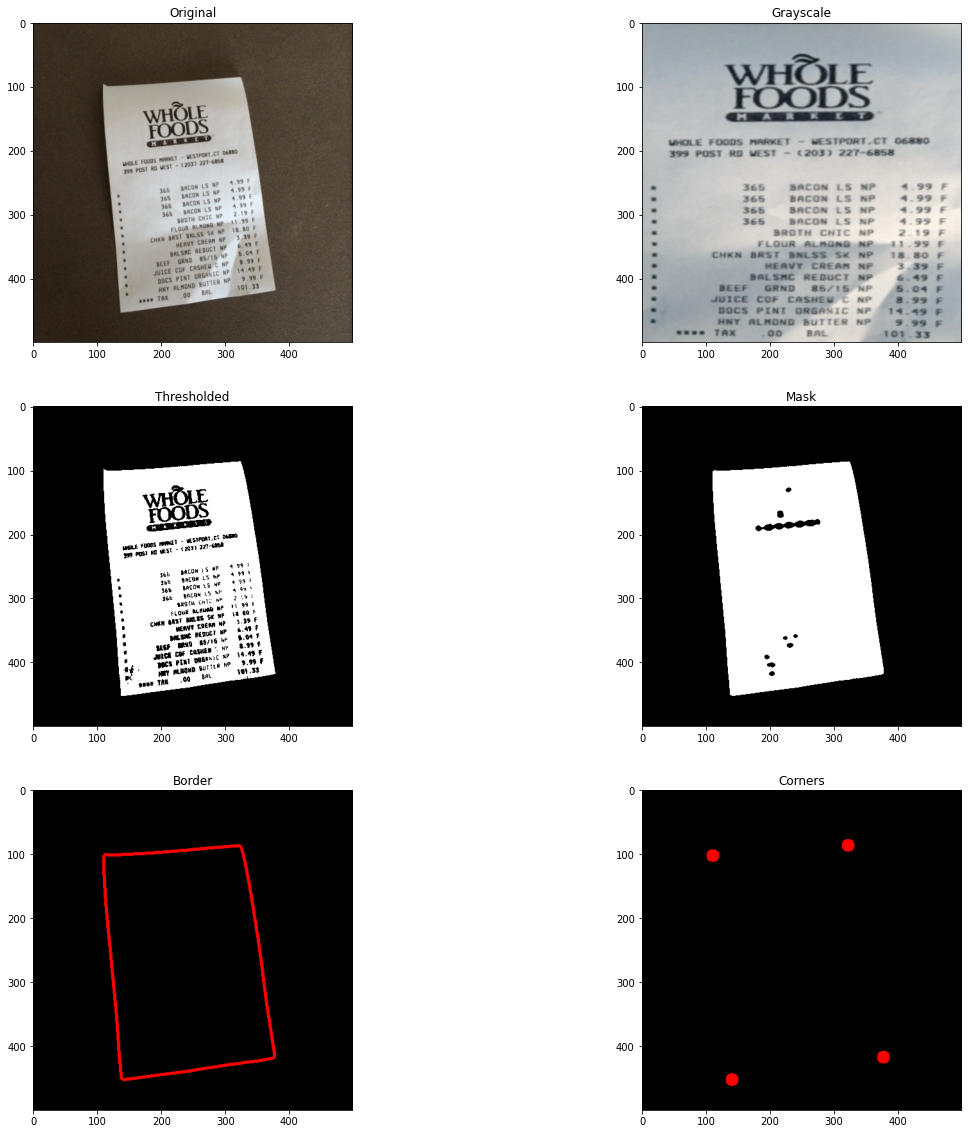

In [9]:
def main():
    img = selectImage()
    cornerPoints, threshold, mask, border, corners, gray = getDocumentCorners(img)
    sorted_pts = sortPoints(cornerPoints)
    warped = warpPerspective(img,sorted_pts)
    showResult(img,warped,threshold,mask,border,corners)

main()